![](https://assets.website-files.com/60e7f71b22c6d0b9cf329ceb/621e1a2f28ded71ee95aeede_6ProvenSalesForecastingMethodstoDriveRevenue1_a117440b5ae227c3dba5264a6521da06_2000.png)

# Introdução

O objetivo deste projeto é desenvolver um modelo de forecasting para prever a demanda dos próximos 5 dias do item da empresa **Frexco**, baseado em uma série temporal. Para essa previsão será utilizado o modelo ARIMA.

# Data Cleaning

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('Dados.xlsx', index_col=0)

In [3]:
df = df.reset_index(level=0)

In [4]:
df.head()

,Data,Vendas
0,2022-12-06,870
1,2022-12-07,868
2,2022-12-08,1189
3,2022-12-09,742
4,2022-12-10,317


In [5]:
df['Data'] = df['Data'].astype(str)

In [6]:
df[['Ano', 'Mes', 'Dia']] = df['Data'].str.split('-', expand=True).astype(int)
df.head()

,Data,Vendas,Ano,Mes,Dia
0,2022-12-06,870,2022,12,6
1,2022-12-07,868,2022,12,7
2,2022-12-08,1189,2022,12,8
3,2022-12-09,742,2022,12,9
4,2022-12-10,317,2022,12,10


# Análise Exploratória de Dados (EDA)

In [7]:
import seaborn as sns
import plotly.express as px

In [8]:
import plotly.io as pio
pio.renderers.default = "svg"

In [9]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


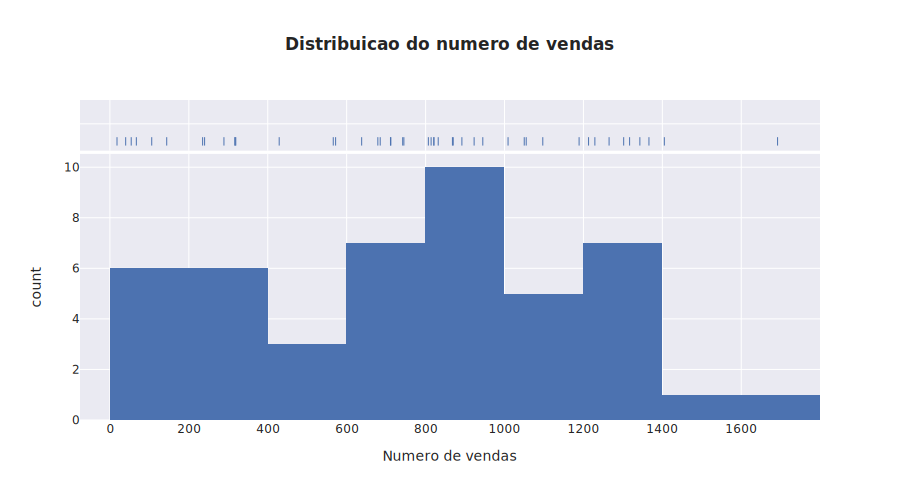

In [10]:
px.histogram(df,x='Vendas', width=900, marginal='rug',template='seaborn',labels={'Vendas':'Numero de vendas'},title="<b> Distribuicao do numero de vendas")

A maior frequência de número de vendas está no intervalo de 800 a 1000 vendas.

In [11]:
vendas = np.array(df['Vendas'])

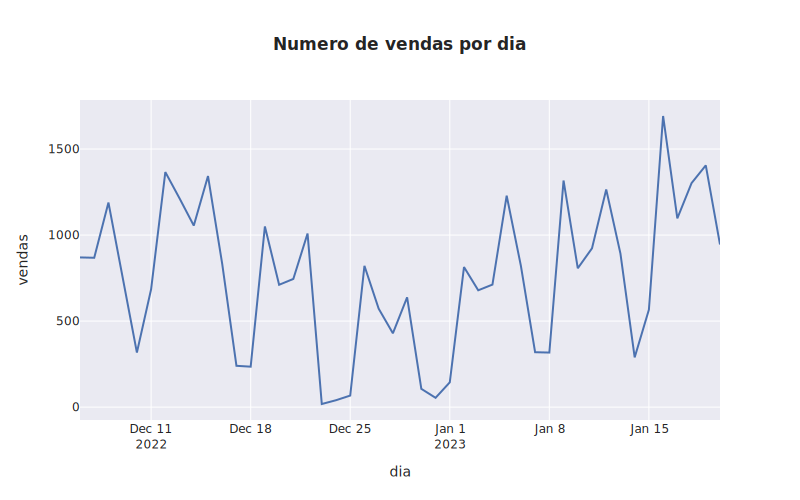

In [12]:
fig = px.line(df, x="Data", y="Vendas", width=800, labels={'Data':'dia','Vendas':'vendas'}, template="seaborn",title="<b> Numero de vendas por dia")
fig.show()

In [13]:
z = df.sort_values('Vendas', ascending=False).reset_index(drop=True)

In [14]:
z = z[['Data', 'Vendas']]

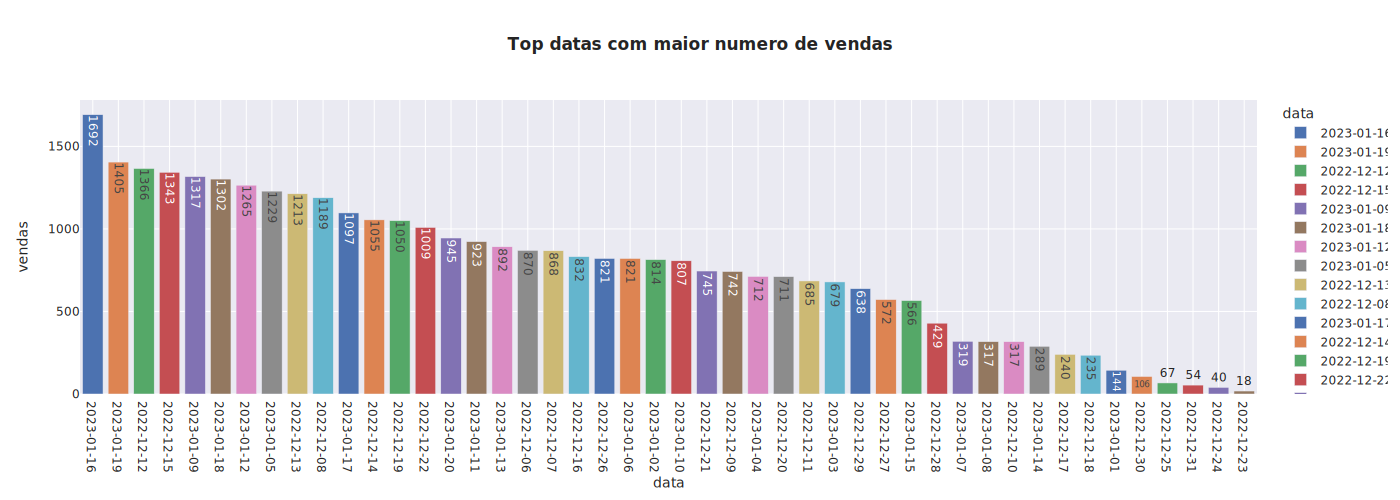

In [15]:
fig=px.bar(z,x='Data',y='Vendas',color='Data', width=1400,
           labels={'Data':'data','Vendas':'vendas'},text='Vendas',template='seaborn',title="<b> Top datas com maior numero de vendas")

fig.update_layout(
xaxis_type = 'category'
)

fig.show()

In [16]:
z = df[df['Dia'] <= 20]
z = df.groupby('Mes', as_index=False)[['Vendas']].sum().sort_values(by='Vendas',ascending=False)
z = z.replace(1, 'Janeiro de 2023')
z = z.replace(12, 'Dezembro de 2022')

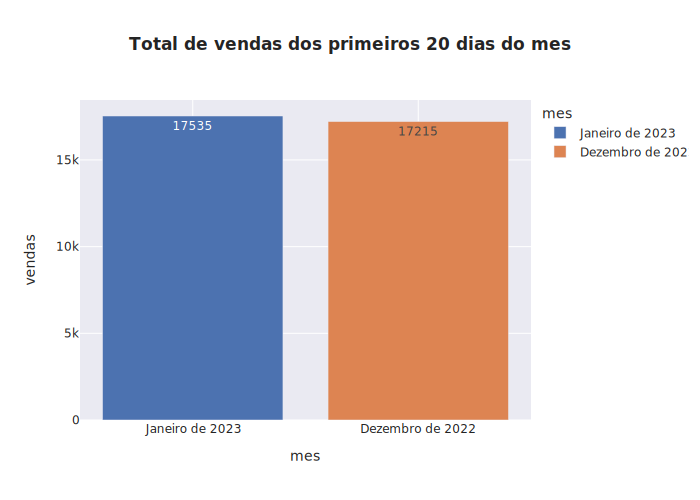

In [17]:
fig=px.bar(z,x='Mes',y='Vendas',color='Mes',
           labels={'Mes':'mes','Vendas':'vendas'},text='Vendas',template='seaborn',title="<b> Total de vendas dos primeiros 20 dias do mes")

fig.show()

# Machine Learning

## Data Visualization

In [18]:
data = pd.DataFrame(df['Vendas'])

In [19]:
data.head()

,Vendas
0,870
1,868
2,1189
3,742
4,317


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Vendas  46 non-null     int64
dtypes: int64(1)
memory usage: 496.0 bytes


In [21]:
# descrição da coluna de vendas
data.describe()['Vendas']

count      46.000000
mean      755.434783
std       430.762201
min        18.000000
25%       346.500000
50%       810.500000
75%      1053.750000
max      1692.000000
Name: Vendas, dtype: float64

In [22]:
# checando nulos
data.isnull().sum()

Vendas    0
dtype: int64

### Reescalando os dados

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler()

scaler.fit(pd.DataFrame(data['Vendas']))

data['Vendas'] = scaler.transform(pd.DataFrame(data['Vendas']))

In [25]:
data.head()

,Vendas
0,0.268898
1,0.264204
2,1.017629
3,-0.031533
4,-1.029059


## Build Model

### Seleção de hiperparâmetros

#### Checando se os dados são estacionários pelo teste ADF

In [26]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
from pmdarima.arima import ADFTest 

In [28]:
adf = ADFTest(alpha = 0.05)
adf.should_diff(data["Vendas"])

(0.32861105775592403, True)

Como o p-value foi maior que 0.05, isso significa que a série temporal **não é estacionária**.

#### Transformando a time series em estacionária

In [29]:
# aumentando a ordem de diferenciação

data["diff_1"] = data["Vendas"].diff(periods=1)
data["diff_2"] = data["Vendas"].diff(periods=2)
data["diff_3"] = data["Vendas"].diff(periods=3)

In [30]:
adf = ADFTest(alpha = 0.05)
print(f'p-value diff 1: {adf.should_diff(data["diff_1"].dropna())}')
print(f'p-value diff 2: {adf.should_diff(data["diff_2"].dropna())}')
print(f'p-value diff 3: {adf.should_diff(data["diff_3"].dropna())}')

p-value diff 1: (0.01, False)
p-value diff 2: (0.01, False)
p-value diff 3: (0.01, False)


Os dados agora **são estacionários**, e somente 1 grau de diferenciação (**d=1**) foi necessário.

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

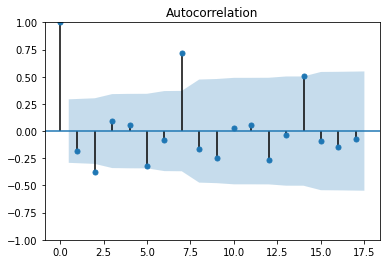

In [32]:
plot_acf(data['diff_1'].dropna());

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



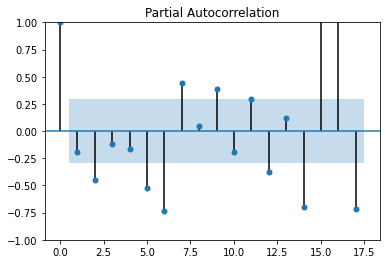

In [33]:
plot_pacf(data['diff_1'].dropna());

Analisando o gráfico de autocorrelação e o desempenho do modelo, os parâmetros escolhidos foram: **p=7; d=1; q=1**

## Fit

In [34]:
from statsmodels.tsa.arima.model import ARIMA

In [35]:
import warnings
warnings.filterwarnings("ignore")

# build model
model = ARIMA(data.Vendas, order=(7, 1, 1))

In [36]:
model = model.fit()

## Evaluate

In [37]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Vendas   No. Observations:                   46
Model:                 ARIMA(7, 1, 1)   Log Likelihood                 -35.213
Date:                Sat, 04 Feb 2023   AIC                             88.425
Time:                        20:56:59   BIC                            104.685
Sample:                             0   HQIC                            94.487
                                 - 46                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1666      0.306     -0.545      0.586      -0.766       0.433
ar.L2         -0.1996      0.235     -0.850      0.395      -0.660       0.261
ar.L3         -0.1709      0.259     -0.660      0.510      -0.679       0.337
ar.L4         -0.1320      0.207     -0.638      0.524      -0.537       0.274
ar.L5         -0.1951      0.190     -1.025      0.305      -0.568       0.178
ar.L6         -0.0964      0.184     -0.525      0.600      -0.456       0.264
ar.L7          0.7191      0.185      3.886      0.000       0.356       1.082
ma.L1         -0.1932      0.441     -0.438      0.661      -1.058       0.671
sigma2         0.2268      0.056      4.059      0.000       0.117       0.336
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.23
Prob(Q):                              0.96   Prob(JB):                         0.54
Heteroskedasticity (H):               1.07   Skew:                            -0.27
Prob(H) (two-sided):                  0.90   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
data_pred = model.predict(dynamic=False)

# Resultados

O **AIC** e **BIC** do modelo foram **88.425** e **104.685**, respectivamente.

## Gráfico Real vs Previsto do modelo ARIMA

In [39]:
import matplotlib.pyplot as plt

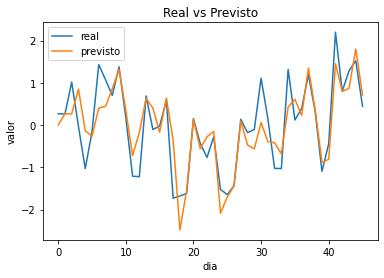

In [40]:
plt.plot(data.Vendas, linestyle = '-', label = 'real')
plt.plot(data_pred, linestyle = '-', label = 'previsto')

plt.xlabel("dia")
plt.ylabel("valor")

plt.title("Real vs Previsto")
plt.legend(loc='best')

plt.show()

## Previsão de vendas dos próximos 5 dias

In [41]:
forecast_next_5_days = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(model.forecast(5))), index = pd.date_range(start='21/1/2023', periods=5)).rename(columns={'index':'Data'})

forecast_next_5_days.columns = ['Vendas']

forecast_next_5_days['Vendas'] = forecast_next_5_days['Vendas'].astype(int)

In [42]:
forecast_next_5_days

,Vendas
2023-01-21,386
2023-01-22,733
2023-01-23,1679
2023-01-24,1140
2023-01-25,1283


*Muito obrigado por vir até o fim :)*